# ADC tests - `20180103a` test of acquisition with a AD08200 ADC pHAT

## Testing Hannes file with AD08200
 

Looks like it works in some way. But we don't see anything on the image. Perhaps something wrong with the gain setting?

Infos from the kernel log:

    Feb  8 22:46:22 raspberrypi kernel: [ 3740.933119] starting acquisition
    Feb  8 22:46:22 raspberrypi kernel: [ 3740.933131] Shooting line 0
    Feb  8 22:46:22 raspberrypi kernel: [ 3740.933557] Shooting line 1
    Feb  8 22:46:22 raspberrypi kernel: [ 3740.933976] Shooting line 2
    Feb  8 22:46:22 raspberrypi kernel: [ 3740.934395] Shooting line 3
    Feb  8 22:46:22 raspberrypi kernel: [ 3740.934813] Shooting line 4
    ...
    Feb  8 22:46:22 raspberrypi kernel: [ 3741.098186] Shooting line 395
    Feb  8 22:46:22 raspberrypi kernel: [ 3741.098605] Shooting line 396
    Feb  8 22:46:22 raspberrypi kernel: [ 3741.099023] Shooting line 397
    Feb  8 22:46:22 raspberrypi kernel: [ 3741.099442] Shooting line 398
    Feb  8 22:46:22 raspberrypi kernel: [ 3741.099860] Shooting line 399
    Feb  8 22:46:22 raspberrypi kernel: [ 3741.100556] returning from acquisition


looks like the acquisition took less than a second. We collected 2000000 datapoints.

0.0
4.9999975
9.999995
14.9999925
19.99999
24.9999875
29.999985
34.9999825
39.99998
44.9999775
49.999975
54.9999725
59.99997
64.9999675
69.999965
74.9999625
79.99996
84.9999575
89.999955
94.9999525
99.99995
2000000
167211327
11.9609121935
go


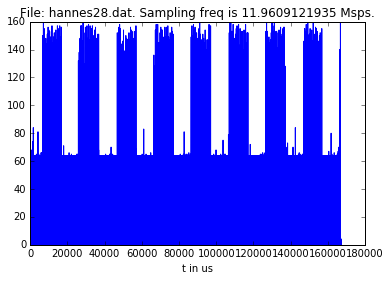

In [131]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.signal import decimate, convolve
import math
from scipy.interpolate import griddata

from DAT2NPZ import *
import glob, os



filename = "hannes28"

#create numpy npz file
CreateNPZ(filename+".dat")

In [132]:
## Opening file

In [133]:
loaded = np.load(filename+'.npz')
t = loaded["t"]
M = loaded["M"]
Fech = loaded["Fech"]
Duration = loaded["Duration"]

#cut of time
M = M[:-1] 

print t.shape
print M.shape



(2000000,)
(2000000,)


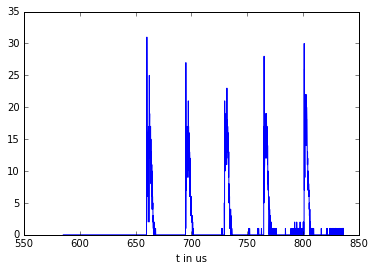

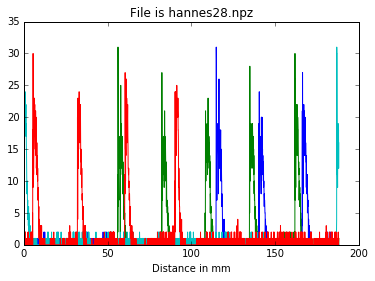

In [134]:
#this part has to be adjusted...
d0 = 7000 #what is this?
dplus = 3000 #what is this?
plt.plot(t[d0:d0+dplus],M[d0:d0+dplus])
plt.xlabel('t in us')
plt.show()

# Let's map this signal in distance
# 2000 pts correspond to ~900-725 = 175us
# a peak at 1m corresponds to 2m in distance. The speed is 1450m/s. So a distance of 1m corresponds to 2/1450 s.
d = []
for k in range(dplus):
    d.append(0.75*t[k] ) ## 1us for 750m/s is 0.75mm
plt.plot(d,M[d0:d0+dplus],"g")
plt.plot(d,M[d0+10000:d0+dplus+10000],"b") #why 10000?
plt.plot(d,M[d0+20000:d0+dplus+20000],"c") #why 20000?
plt.plot(d,M[d0+30000:d0+dplus+30000],"r") #why 30000?
plt.title('File is '+filename+'.npz')
plt.xlabel('Distance in mm') # us in 1e6
plt.savefig(filename+'-detail.png') 
plt.show()

# Bits on the AD08200

Clock: close to 0.25

* D0: 26 - GPIO7
* D1: 24 - GPIO8
* D2: 21 - GPIO9
* D3: 19 - GPI10
* D4: 23 - GPI11
* D5: 16 - GPI23
* D6: 18 - GPI24
* D7: 22 - GPI25

In [135]:
ADC2_GPIO = [7, 8,9,10,11,23,24,25]
ADC2len = len( ADC2_GPIO)

In [136]:
#get the normalized signal
rawSig = M - np.average(M)
print len(rawSig)

2000000


In [137]:
#perform FFT and delete unwanted frequencies
FFT = np.fft.fft(rawSig)
FFTCleaned = np.fft.fft(rawSig)
FStart = 0.068*len(FFTCleaned)
FStop = 0.196*len(FFTCleaned)
for k in range(len(FFTCleaned)/2):
    if (k < FStart or k > FStop): # in (k < 550000 or k > 790000) # 0.068 0.196 #where are these numbers coming from?
        FFTCleaned[k] = 0
        FFTCleaned[-k] = 0

1000000
1000000


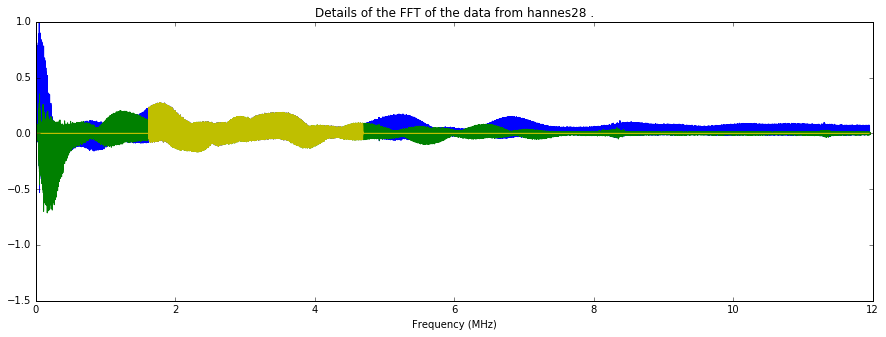

In [138]:
#plot the spectrum and the cleaned spectrum
Scale = max(FFT)
ff = [ Fech*2.0*x/(len(rawSig)) for x in range(len(rawSig)/2)]
plt.figure(figsize=(15,5))
print len(ff)
print len(np.real(FFT)[0:len(FFT)/2]/Scale)
plt.plot(ff,np.real(FFT)[0:len(FFT)/2]/Scale,"b")
plt.plot(ff,np.imag(FFT)[0:len(FFT)/2]/Scale,"g")
plt.plot(ff,np.imag(FFTCleaned)[0:len(FFT)/2]/Scale,"y")
plt.plot(ff,np.real(FFTCleaned)[0:len(FFT)/2]/Scale,"y")
plt.title("Details of the FFT of the data from "+filename.split("/")[-1]+" .")  
plt.xlabel("Frequency (MHz)")
#plt.savefig('Imgs/fft_'+RawData.split("/")[-1]+".png", bbox_inches='tight')
plt.show()

In [139]:
#transfer the cleaned spectrum back to the time domain
F = np.real(np.fft.ifft(FFTCleaned))

In [140]:
#calculate the envelope using a hilbert transform
FH = np.asarray(np.abs(signal.hilbert(F)))

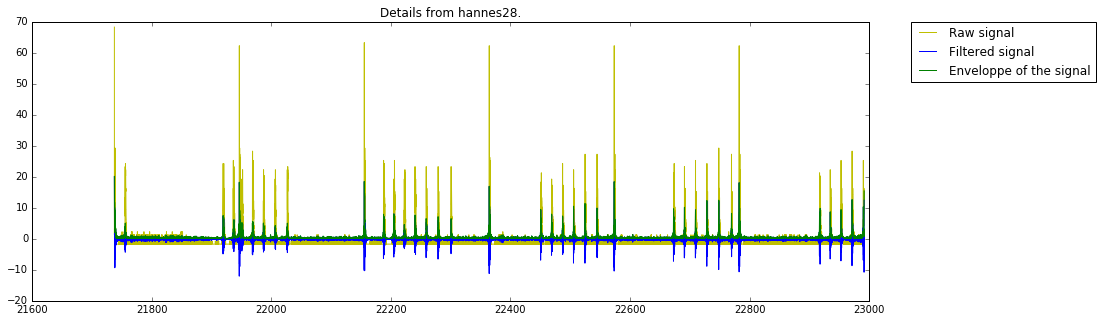

In [141]:
#print the raw signal, filtered signal and envelope on the index line
IndexEmpty = 20 #where does this number come from?
IndexLine = 104 #where does this number come from?
tt = IndexLine*2500 #where does this number come from?
plt.figure(figsize=(15,5))
T = [ (( x * Duration ) / ( 1000.0*len(rawSig) )) for x in 2*range(len(rawSig))]
TT = np.divide(T,2.0)
plt.plot(TT[2*tt:2*tt+2*15000],rawSig[2*tt:2*tt+2*15000],"y", label='Raw signal') #where does this number (15000) come from?
plt.plot(TT[2*tt:2*tt+2*15000],np.real(np.fft.ifft(FFTCleaned))[2*tt:2*tt+2*15000],"b", label='Filtered signal')
plt.plot(TT[2*tt:2*tt+2*15000],FH[2*tt:2*tt+2*15000],"g", label='Enveloppe of the signal')
plt.title("Details from "+filename.split("/")[-1]+".")  
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig('Imgs/datas_'+RawData.split("/")[-1]+'.png', bbox_inches='tight')
plt.show()


In [147]:
#the reshape the signal
#tableData = np.asarray(FH).reshape((1000,2*2500)) where are these dimensions coming from??
#tableDataRaw = np.asarray(rawSig).reshape((1000,2*2500))

#randomly trying out dimensions...
#ydim = 2500
#xdim = n/ydim
repeat_size = 400 #repeat size
sample_size = 5000 #sample size

#reshape envelope of filtered signal
#tableData = np.asarray(FH).reshape((repeat_size,sample_size))


#FOR NOW; WE USE THE RAW SIGNAL!!!
#reshape envelope of raw signal
tableData = np.asarray(rawSig).reshape((repeat_size,sample_size))

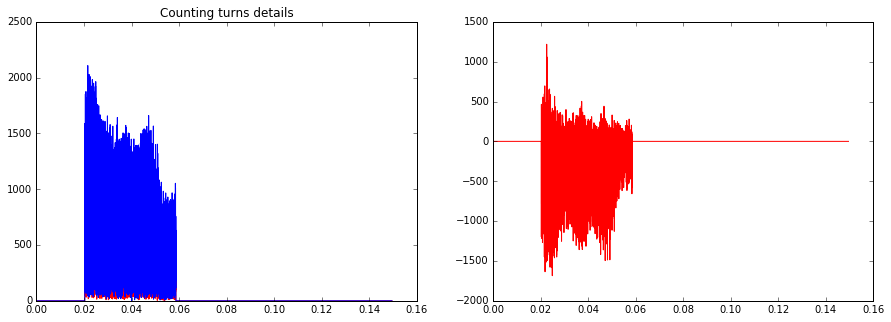

In [143]:
#not sure what this plot is used for...
EmptyLine = rawSig[5000*IndexEmpty:5000*IndexEmpty+25000]
FullLine = rawSig[5000*IndexLine:5000*IndexLine+25000]
FFul = np.fft.fft(FullLine)
FFem = np.fft.fft(EmptyLine)
for i in range(len(FullLine)/2):
    if (i < 1700 or i > 4900):
        FFul[i] = 0
        FFem[i] = 0
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(ff[0:len(FullLine)/2],np.abs(FFul)[0:len(FullLine)/2],"r")
ax1.plot(ff[0:len(FullLine)/2],np.abs(FFem)[0:len(FullLine)/2],"b")
ax1.set_title('Counting turns')

ax1.set_title('Counting turns details')
diff = np.abs(FFul) - np.abs(FFem)
ax2.plot(ff[0:len(FullLine)/2],diff[0:len(FullLine)/2],"r")
plt.show()

3000
3000


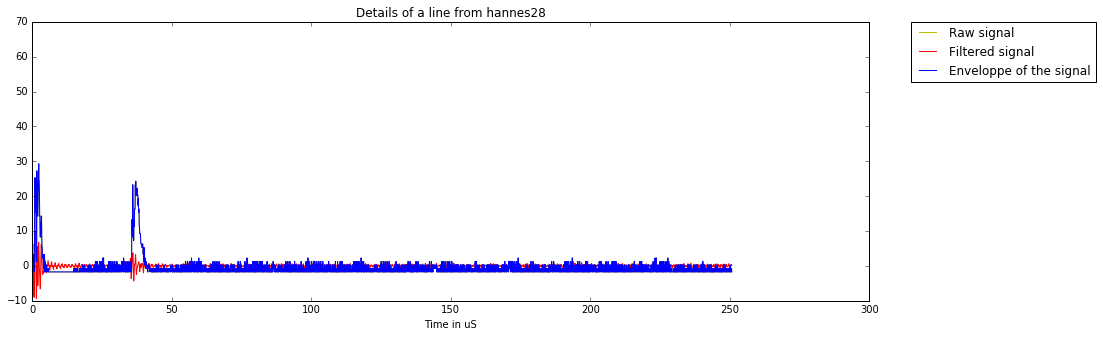

In [151]:
ExLine = tableData[IndexLine]
ExLineRaw = tableData[IndexLine]
plt.figure(figsize=(15,5))
plt.plot(T[0:3000],rawSig[5000*IndexLine:5000*IndexLine+3000],"y", label='Raw signal')
plt.plot(T[0:3000],F[5000*IndexLine:5000*IndexLine+3000],"r", label='Filtered signal')
plt.plot(T[0:3000],ExLine[0:3000],"b", label='Enveloppe of the signal')
print len(T[0:3000])
print len(ExLine[0:3000])
#the dimensions are not matching. guess theres something wrong with the dimensions of tableData
plt.title("Details of a line from "+filename.split("/")[-1])
plt.xlabel("Time in uS")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('Imgs/ProcessingLine_'+filename.split("/")[-1]+".png", bbox_inches='tight')
plt.show()

In [145]:
#add an offset to the image, will do that later
#get average value
Val = np.average(tableData)
#tableData = np.asarray(FH).reshape((1000,2*2500))
Offset = 400
MinTable = 10*np.min(tableData)
Zeroes = np.zeros((repeat_size,Offset))+Val
BigTable = []
BigTable = np.append(Zeroes, tableData, axis=1)

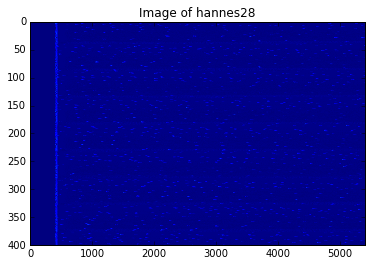

In [150]:
#plot the reshaped data
#there are some dots, so guess the file contains data
plt.imshow((abs(BigTable)), aspect='auto')
plt.title("Image of "+filename.split("/")[-1])
#plt.axhline(IndexLine, color='r', linestyle='--')
#plt.title("Mapping the data from "+RawData.split("/")[-1]+" .")  
plt.savefig('Imgs/map_'+filename.split("/")[-1]+".png", bbox_inches='tight')
plt.show()

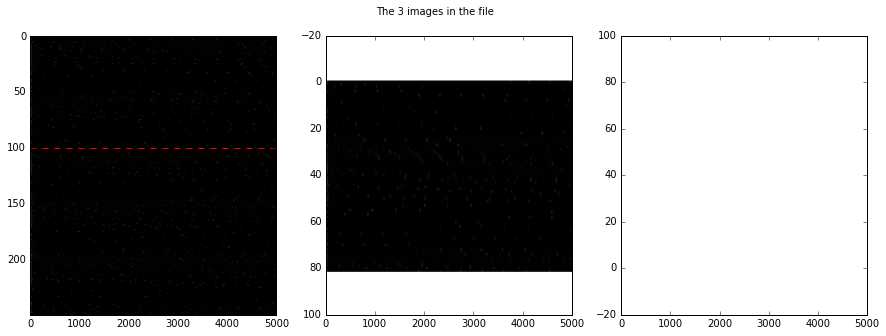

In [108]:
#this is plotting the images of the three runs. but we only have one...
ListOfPoints= [104, 418, 741]#where are these numbers coming from?

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

TmpImg = (abs(tableData[ListOfPoints[0]-100:ListOfPoints[0]+150]))**(1.1)
ax1.imshow(TmpImg,cmap=plt.get_cmap('gray'), aspect='auto')
ax1.axhline(100, color='r', linestyle='--')
TmpImg = (abs(tableData[ListOfPoints[1]-100:ListOfPoints[1]+150]))**(1.1)
ax2.imshow(TmpImg,cmap=plt.get_cmap('gray'), aspect='auto')
ax2.axhline(100, color='r', linestyle='--')
TmpImg = (abs(tableData[ListOfPoints[2]-100:ListOfPoints[2]+150]))**(1.1)
ax3.imshow(TmpImg,cmap=plt.get_cmap('gray'), aspect='auto')
ax3.axhline(100, color='r', linestyle='--')
plt.suptitle('The 3 images in the file')
#plt.savefig('Imgs/images_'+RawData.split("/")[-1]+".png", bbox_inches='tight')
#plt.savefig('Imgs/mapCleanImage_'+RawData.split("/")[-1]+str(Start)+"-"+str(Stop)+".jpg", bbox_inches='tight')
plt.show()

In [109]:
#this makes one image out of the 3 runs, guess this is for noise reduction.
#we cannot do this because we only have 1 run
DecImg = []
for i in range(150):
    tmp = decimate(tableData[ListOfPoints[0]-70+i], 5, ftype='fir')
    #tmp += decimate(tableData[ListOfPoints[1]-70+i], 5, ftype='fir')
    #tmp += decimate(tableData[ListOfPoints[2]-70+i], 5, ftype='fir')
    DecImg.append(tmp)

In [110]:
#downsample the image, don't know if this is really necessary
SmallImg = []
for i in range(len(DecImg)/2):
    SmallImg.append((DecImg[2*i]+DecImg[2*i+1])/2)

In [111]:
#function to rotate and shring the image
def CreateSC(RawImgData):
    LenLinesC = np.shape(RawImgData)[1]
    NbLinesC = np.shape(RawImgData)[0]
    SC = np.zeros((LenLinesC,LenLinesC))+Val
    SC += 1
    maxAngle = 60.0
    step = maxAngle/(NbLinesC+1)
    CosAngle = math.cos(math.radians(30))
    Limit = LenLinesC*CosAngle

    points = []
    values = []

    for i in range(LenLinesC):
        for j in range(LenLinesC):
            if (  (j > LenLinesC/2 + i/(2*CosAngle)) or  (j < LenLinesC/2 - i/(2*CosAngle)) ):
                SC[i][j] = 0
                points.append([i,j])
                values.append(0)
            if (  (i > Limit) ):
                if ( (i**2 + (j-LenLinesC/2) ** 2) > LenLinesC**2):
                    SC[i][j] = 0 
                    points.append([i,j])
                    values.append(0)
    for i in range(NbLinesC):
        PointAngle = i*step-30
        COS = math.cos(math.radians(PointAngle))
        SIN = math.sin(math.radians(PointAngle))
        for j in range(LenLinesC):

            X = (int)( j*COS)
            Y = (int)(LenLinesC/2 - j*SIN)
            SC[X][Y] = RawImgData[i][j]
            points.append([X,Y])
            values.append(RawImgData[i][j])

    values = np.array(values,dtype=np.int)
    
    return SC,values,points,LenLinesC

In [112]:
#create the rotated shrinked image
SCH,valuesH,pointsH,LenLinesCH = CreateSC(SmallImg)
grid_xH, grid_yH = np.mgrid[0:LenLinesCH:1, 0:LenLinesCH:1]
grid_z1H = griddata(pointsH, valuesH, (grid_xH, grid_yH), method='linear')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


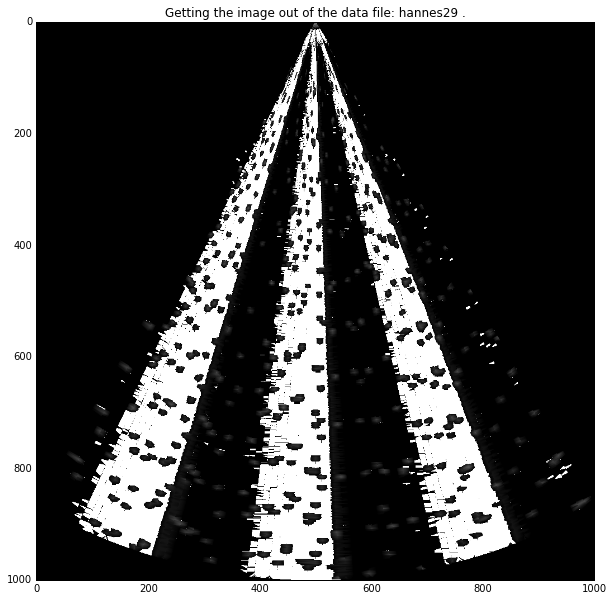

In [113]:
#plot it
plt.figure(figsize=(10,10))
plt.imshow((grid_z1H**0.7),cmap=plt.get_cmap('gray')) 
plt.title("Getting the image out of the data file: "+filename.split("/")[-1]+" .")  
#plt.savefig('Imgs/pic_'+RawData.split("/")[-1]+".png", bbox_inches='tight')
plt.show()